In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Predict stroke

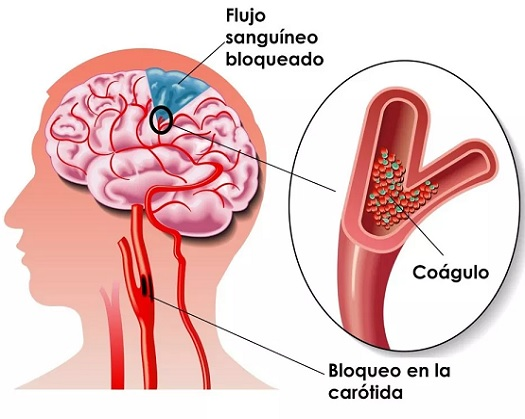

## Attribute Information

1) id: unique identifier


2) gender: "Male", "Female" or "Other"


3) age: age of the patient


4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension


5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease


6) ever_married: "No" or "Yes"


7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"


8) Residence_type: "Rural" or "Urban"


9) avg_glucose_level: average glucose level in blood


10) bmi: body mass index


11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*


12) stroke: 1 if the patient had a stroke or 0 if not



* Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# We load the information, the unique identifier of the patient does not provide
# relevant information of the condition so it will be eliminated 
df=pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv').drop(columns='id')

We have 201 lost cases for the bmi information (Body Mass Index), so a dropna () of will be performed to eliminate those rows of missing data 

In [ ]:
df.info()

In [ ]:
df=df.dropna()
df=df.reset_index(drop=True)

# Analysis of the information 

## Distribution of our numerical data (bmi, age, avg_glucose_level) 

In [ ]:
# Estilos disponibles para plt.style.use()
#print(plt.style.available)
plt.style.use('seaborn-whitegrid')

In [ ]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams['figure.figsize']=(20,5)
plt.subplot(1,3,1)
sns.distplot(df['age'], kde=True, color='b')
plt.ylabel('Density')
plt.axvline(df['age'].mean(),color='r', label='mean of age')
plt.axvline(df['age'][df['stroke']==1].mean(), color='black', label='mean age of stroke')
plt.legend()
plt.title('Histogram of Age')

plt.subplot(1,3,2)
sns.distplot(df['bmi'], kde=True, color='b')
plt.ylabel('Density')
plt.axvline(df['bmi'][df['stroke']==1].mean(), color='black', label='mean bmi stroke')
plt.legend()
plt.title('Histogram of Bmi')



plt.subplot(1,3,3)
sns.distplot(df['avg_glucose_level'], kde=True, color='b')
plt.ylabel('Density')
plt.axvline(df['avg_glucose_level'][df['stroke']==1].mean(), color='black', label='mean glucose stroke')
plt.legend()
plt.title('Histogram of glucose level')

plt.show()



3 things are appreciated according to the histograms:

The normal body mass index ranges from (18.5 to 25), overweight from (25 to 30) and obesity more than 30. We have that our average for an attack is greater than 30 so it would be more common for obese people.

A fasting blood glucose level below 100 mg / dl is considered normal, a level between 100 and 125 mg / dL is considered prediabetes, a glucose level above 126 mg / dL or higher indicates type 2 diabetes. case presents an average of over 126 mg / dl so it could be said that stroke is related to diabetes.

Finally, the average age for this condition to occur is close to 68 years, which is why it is common in older people than in young adults. 

## Categorical variable graphs 

In [ ]:
plt.rcParams['figure.figsize']=(20,15)
plt.style.use('seaborn-white')
plt.subplot(4,2,1)
sns.barplot(data=df,x="gender", y="stroke", hue="hypertension",palette="Paired")

plt.subplot(4,2,2)
sns.countplot(data=df,x="stroke", hue="hypertension",palette="Paired",edgecolor="white")


plt.subplot(4,2,3)
sns.barplot(data=df,x="gender", y="stroke", hue="heart_disease",palette="Paired")

plt.subplot(4,2,4)
sns.countplot(data=df,x="stroke", hue="heart_disease",palette="Paired",edgecolor="white")



plt.subplot(4,2,5)
sns.barplot(data=df,x="gender", y="stroke", hue="ever_married",palette="Paired")

plt.subplot(4,2,6)
sns.countplot(data=df,x="stroke", hue="ever_married",palette="Paired",edgecolor="white")

plt.subplot(4,2,7)
sns.barplot(data=df,x="gender", y="stroke", hue="Residence_type",palette="Paired")

plt.subplot(4,2,8)
sns.countplot(data=df,x="stroke", hue="Residence_type",palette="Paired",edgecolor="white")


plt.show()

It is observed that the presence of heart diseases and hypertension are related to the occurrence of a cerebrovascular accident, on the other hand, to a lesser extent, there is an increase in cases of cardiovascular accidents due to the place where you live, which can be associated with stress. 

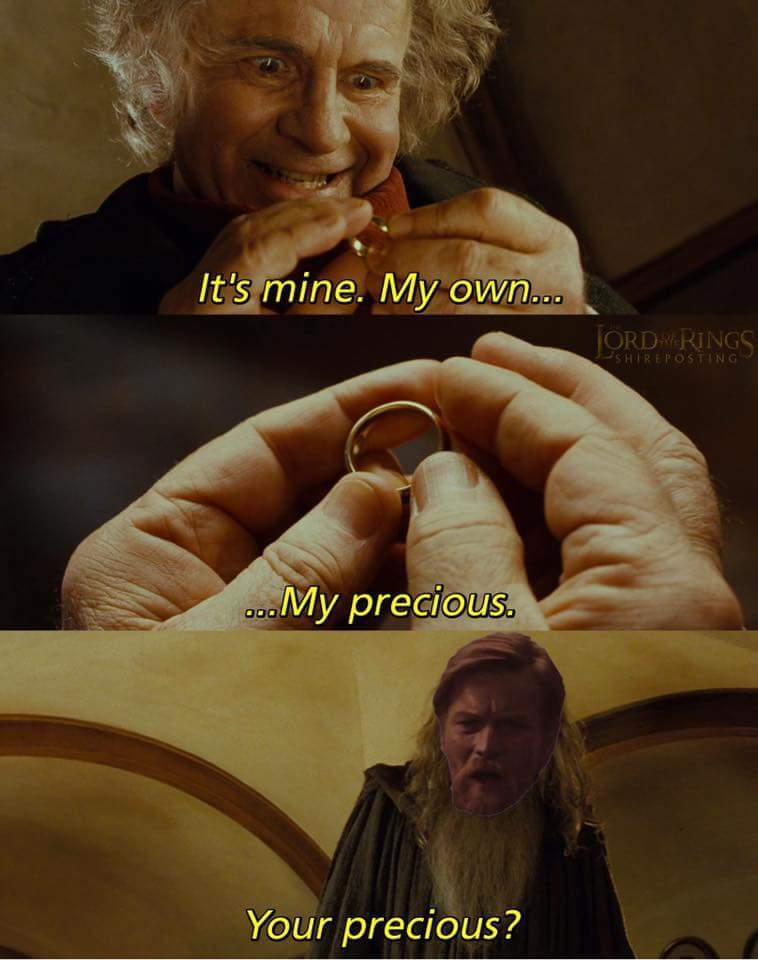

In [ ]:
plt.rcParams['figure.figsize']=(20,6)

plt.subplot(1,2,1)

sns.distplot(df['bmi'][df['ever_married']=='Yes'], kde=True, color='b')
plt.ylabel('Density')
plt.axvline(df['bmi'][df['ever_married']=='Yes'].mean(),color='r', label='mean of bmi ever married')
plt.legend()
plt.title('Histogram of bmi')

plt.subplot(1,2,2)
sns.distplot(df['bmi'][df['ever_married']=='No'], kde=True, color='b')
plt.ylabel('Density')
plt.axvline(df['bmi'][df['ever_married']=='No'].mean(),color='r', label='mean of bmi not married')
plt.legend()
plt.title('Histogram of bmi')

plt.show()

It happens that marriage makes people fat is a proven fact, that the tendency is to gain a few kilos when getting married and have a more sedentary life.

As we can see that the average body mass index is closer to the normal range for people who are married. In the case of people who got married, the average is close to obesity and along with this are usually the other associated diseases. 

In [ ]:
plt.rcParams['figure.figsize']=(20,15)
plt.subplot(2,2,1)
sns.barplot(data=df,x="stroke", y="gender", hue="work_type",palette="Paired",edgecolor="white",ci=None)
plt.xlabel('Density of Stroke')
plt.legend(loc='lower right')
plt.title('Work type')


plt.subplot(2,2,2)
sns.countplot(data=df,y="stroke", hue="work_type",palette="Paired",edgecolor="white")




plt.subplot(2,2,3)
sns.barplot(data=df,x="stroke", y="gender", hue="smoking_status",palette="Paired",edgecolor="white",ci=None)
plt.xlabel('Density of Stroke')
plt.title('Smoking status')
plt.legend(loc='lower right')

plt.subplot(2,2,4)
sns.countplot(data=df,y="stroke", hue="smoking_status",palette="Paired",edgecolor="white")


plt.show()

It is observed that in the cases of self-employed workers they are more prone to the occurrence of a cerebrovascular accident, which may be due to the level of stress that the person handles.

On the other hand, in the case of frequent smokers, it is appreciated that there is a significant increase in the possibility of a stroke. 

Before continuing we are going to appreciate how many cases of stroke we have in our data 

In [ ]:
df_atack= pd.DataFrame(df['gender'][df['stroke']==1].value_counts())
df_atack= df_atack.rename_axis("label").reset_index()
df_atack.replace(['Female','Male'],['Female stroke','Male stroke'], inplace =True)
df_no_atack=pd.DataFrame( df['gender'][df['stroke']==0].value_counts())
df_no_atack= df_no_atack.rename_axis("label").reset_index()

In [ ]:
df_cantidad=pd.concat([df_atack,df_no_atack])

In [ ]:
fig = px.pie(df_cantidad, values='gender', names='label', title='Number of cases in the data')
fig.show()

We see that there is a great imbalance between the classes, which will harm us when we carry out our classification models to identify stroke cases, which will be solved by oversampling the class that presents less case than the X_train when the information split is carried out. 

## Transform the categorical columns 

In [ ]:
category=df.dtypes=='object'
category= list(category[category].index)
print(category)

In [ ]:
df_mod=df.copy()

We are going to make a copy to keep the original DataFrame and we are going to create the LabelBinarizer function 

In [ ]:
gender=LabelBinarizer()
ever_married=LabelBinarizer()
Residence_type=LabelBinarizer()

df_mod['gender']=gender.fit_transform(df_mod['gender'])
df_mod['ever_married']=ever_married.fit_transform(df_mod['ever_married'])
df_mod['Residence_type']=Residence_type.fit_transform(df_mod['Residence_type'])

In [ ]:
smoking_status=LabelBinarizer().fit(df_mod['smoking_status'])
df_mod=pd.concat( [df_mod.drop(columns='smoking_status'), pd.DataFrame(smoking_status.transform(df_mod['smoking_status']),
                                                           columns=smoking_status.classes_)], axis=1)

In [ ]:
work_type=LabelBinarizer().fit(df_mod['work_type'])
df_mod=pd.concat( [df_mod.drop(columns='work_type'), pd.DataFrame(work_type.transform(df_mod['work_type']),
                                                           columns=work_type.classes_)], axis=1)

In [ ]:
df_mod.head()

there are variables that are much larger than one so standarscaler will be used to rescale them 

In [ ]:
y=df_mod['stroke']
df_mod=df_mod.drop(columns='stroke')
Standar=StandardScaler()
datos_escalados=Standar.fit_transform(df_mod)
column=df_mod.columns

In [ ]:
X=pd.DataFrame(datos_escalados,columns=column)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1125)

## Oversampling is performed 

In [ ]:
# we use smote () to balance the minority class. 
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [ ]:
# LinearSVC()
lin_svc = LinearSVC()
lin_svc.fit(X_resampled, y_resampled)
Y_pred = lin_svc.predict(X_test)

In [ ]:
print(classification_report(y_test, Y_pred))

In [ ]:
svc = LinearSVC()
parameters={'penalty':('l1', 'l2'),
            'C':[0.009,0.12,0.2,0.5,1],
           'class_weight':('balanced',None)}
clf=GridSearchCV(svc,param_grid=parameters,
                cv=5)
clf.fit(X_resampled, y_resampled)

In [ ]:
clf_best = clf.best_estimator_

In [ ]:
Y_pred = clf_best.predict(X_test)
print(classification_report(y_test,Y_pred))

When using a gridsearch the values improved but not enough other models were tested to compare. 

In [ ]:
# AdaBoost Classifier (Adaptive Boosting)

abc_params = {'learning_rate': [0.01, 0.1, 1], 
              'n_estimators': [50, 100, 500, 1000]}

model_abc = GridSearchCV(AdaBoostClassifier(random_state=1234),
                         abc_params,
                         cv=5,
                         n_jobs=-1
                        ).fit(X_resampled, y_resampled)

In [ ]:
bes_ada=model_abc.best_estimator_

In [ ]:
Y_pred = bes_ada.predict(X_test)
print(classification_report(y_test, Y_pred))

It has good accuracy 91% but it is not a good model, it does not give a good result in the variable that we want to predict, it is better to have a greater amount of recall in this case for class 1. 

In [ ]:
# GradientBoosting Classifier

gbc_params = {'learning_rate': [0.01, 0.1, 0.5], 
              'n_estimators': [50, 100, 500], 
              'subsample': [0.1,0.5,0.9],
              'max_features': ['sqrt', 'log2']}
 

gs_gbc2 = GridSearchCV(GradientBoostingClassifier(), 
                       gbc_params, 
                       n_jobs=-1,
                       cv=5).fit(X_resampled, y_resampled)

In [ ]:
best_gbc2 = gs_gbc2.best_estimator_

In [ ]:
Y_pred = best_gbc2.predict(X_test)
print(classification_report(y_test, Y_pred))

In [ ]:
def plot_cm(y_true, y_pred, figsize=(8,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0.0%'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Valores Verdaderos'
    cm.columns.name = 'Prediccion'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
plot_cm(y_test,Y_pred)

# Conclusions



GradientBoosting Classifier was the one that gave us the best metrics, greater precision and recall of the class sought. But I think the model is overfitting, it would be very good to test it with a different dataset to verify how well it actually behaves.

For these medical cases, I think it is a better recall for the prediction since if you make a mistake in giving a false negative, people relax with their health. Not so in the other case, that you put them on alert to take care of themselves. 

I would like to know your opinion. 